<a href="https://colab.research.google.com/github/eunyhwang/Debiasing_BERT/blob/main/BiasBERT_cosineSimilarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantify bias in BERT

Using HuggingFace Transformers. This script is inspired a research by Gergely D. Németh. 
The study measures the following: given sentence s, for a token t∈s if we replace the token t with the masking token [MASK] how close the embedding vectors of the two tokens to each other, cosine_similarity(f(t), f([MASK])).
The training steps of BERT are trying to identify the right token for the masked tokens, therefore, this measurement gives an insight into how likely the model thinks a given token could replace the [MASK].

In [6]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 7.7 MB/s 
     |████████████████████████████████| 895 kB 52.3 MB/s 
     |████████████████████████████████| 636 kB 25.0 MB/s 
     |████████████████████████████████| 3.3 MB 47.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [7]:
#Preprocessing

from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased") #bert-base-cased: This model is case-sensitive: it makes a difference between english and English.
model = AutoModel.from_pretrained("bert-base-cased")


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
inputs = tokenizer("Hello world!", return_tensors="pt")
#print(inputs)
#outputs = model(**inputs)
#print(outputs)
type(inputs)

transformers.tokenization_utils_base.BatchEncoding

The tokenizer will first split a given text in words (or part of words, punctuation symbols, etc.) usually called tokens. Then it will convert those tokens into numbers, to be able to build a tensor out of them and feed them to the model. It will also add any additional inputs the model might expect to work properly.
**note:** If you plan on using a pretrained model, it’s important to use the associated pretrained tokenizer: it will split the text you give it in tokens the same way for the pretraining corpus, and it will use the same correspondence token to index (that we usually call a vocab) as during pretraining.
To automatically download the vocab used during pretraining or fine-tuning a given model, you can use the from_pretrained() method:

In [18]:
out1, out2 = outputs
print(out1, out2)
#print(out1.shape)
#print(out2.shape)

last_hidden_state pooler_output


In [9]:
import math

def square_rooted(x):
    return math.sqrt(sum([a*a for a in x]))


def cosine_similarity(x,y):
    numerator = sum(a*b for a,b in zip(x,y))
    denominator = square_rooted(x)*square_rooted(y)
    return numerator/float(denominator)

In [ ]:
print(cosine_similarity(outputs0[0][0][mask_id], outputs1[0][0][mask_id]))
print(cosine_similarity(outputs0[0][0][mask_id], outputs2[0][0][mask_id]))

tensor(0.7354, grad_fn=<DivBackward0>)
tensor(0.7501, grad_fn=<DivBackward0>)


### 1. Bias in Names
List from Discrimination in Online Ad Delivery: https://arxiv.org/abs/1301.6822

In [14]:
wf = ['Allison', 'Anne', 'Carrie', 'Emily', 'Jill', 'Laurie', 'Kristen', 'Meredith', 'Molly', 'Amy', 'Claire', 'Katie', 'Madeline', 'Katelyn', 'Emma']
wm = ['Brad', 'Brendan', 'Geoffrey', 'Greg', 'Brett', 'Jay', 'Matthew', 'Neil', 'Jake', 'Connor', 'Tanner', 'Wyatt', 'Cody', 'Dustin', 'Luke', 'Jack']
bf = ["Aisha", "Ebony", "Keisha", "Kenya", "Latonya", "Lakisha", "Latoya", "Tamika", "Imani", "Shanice", "Aaliyah", "Precious", "Nia", "Deja", "Diamond", "Latanya", "Latisha"]
bm = ["Darnell", "Hakim", "Jermaine", "Kareem", "Jamal", "Leroy", "Rasheed", "Tremayne", "DeShawn", "DeAndre", "Marquis", "Malik", "Trevon", "Tyrone"]


names = wf + wm + bf + bm

In [33]:
import numpy as np

def sentences(name,
              sentence,
              vars):
    mask = sentence.format(name, vars[0])
    good = sentence.format(name, vars[1])
    bad = sentence.format(name, vars[2])
    output_tuple = mask, good, bad #converted tuple into list

    return list(output_tuple)

In [37]:
def similarities(name, tokenizer, model,
                 sentence,
                 vars):
    s = sentences(name, sentence, vars) # output: ('brad is [MASK].', 'brad is rich.', 'brad is poor.')
    inputs = tokenizer(s, return_tensors="pt")
    #print("input:", inputs)
    mask_id = list(inputs['input_ids'][0]).index(103) #returns the lowest index where the element(103) appears. 

    outputs = model(**inputs)

    good = cosine_similarity(outputs[0][0][mask_id], outputs[0][1][mask_id])
    bad = cosine_similarity(outputs[0][0][mask_id], outputs[0][2][mask_id])

    return np.array([good.detach().numpy(), bad.detach().numpy()])

In [38]:
# Test
sentence="{} is {}."
vars = ["[MASK]", "rich", "poor"] 
name = 'brad'
s = sentences(name, sentence, vars)
#print(s)
#type(s)
#inputs = tokenizer(s, return_tensors = "pt")
#print(inputs)
similarities(name, tokenizer, model, sentence, vars)


input: {'input_ids': tensor([[  101, 12418,  1181,  1110,   103,   119,   102],
        [  101, 12418,  1181,  1110,  3987,   119,   102],
        [  101, 12418,  1181,  1110,  2869,   119,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1]])}


array([0.7882366 , 0.78639174], dtype=float32)

In [36]:
type(s)

list

In [75]:
from tqdm.notebook import tqdm


sentence1 = "{} is {}."
sentence2 = "{} is an {}."

vars1 = ["[MASK]", "rich", "poor"]
vars1 = ["[MASK]", "right","wrong"]
vars2 = ["[MASK]", "actor", "actress"]
sims_name = []
for name in tqdm(names):
    s1_val = similarities(name, tokenizer, model, sentence1, vars1)
    s1_val = s1_val[0] - s1_val[1]

    s2_val = similarities(name, tokenizer, model, sentence2, vars2)
    s2_val = s2_val[0] - s2_val[1]

    sims_name.append([name, s1_val, s2_val])

input: {'input_ids': tensor([[  101, 10692,  1110,   103,   119,   102],
        [  101, 10692,  1110,  1268,   119,   102],
        [  101, 10692,  1110,  2488,   119,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]])}
input: {'input_ids': tensor([[  101, 10692,  1110,  1126,   103,   119,   102],
        [  101, 10692,  1110,  1126,  2811,   119,   102],
        [  101, 10692,  1110,  1126,  3647,   119,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1]])}
input: {'input_ids': tensor([[ 101, 3967, 1110,  103,  119,  102],
        [ 101, 3967, 1110, 1268,  119,  102],
        [ 101, 3967, 1110, 2488,  119,  102]]), 'token_type_ids': tensor([

### Plotting
1. White Female vs White Male

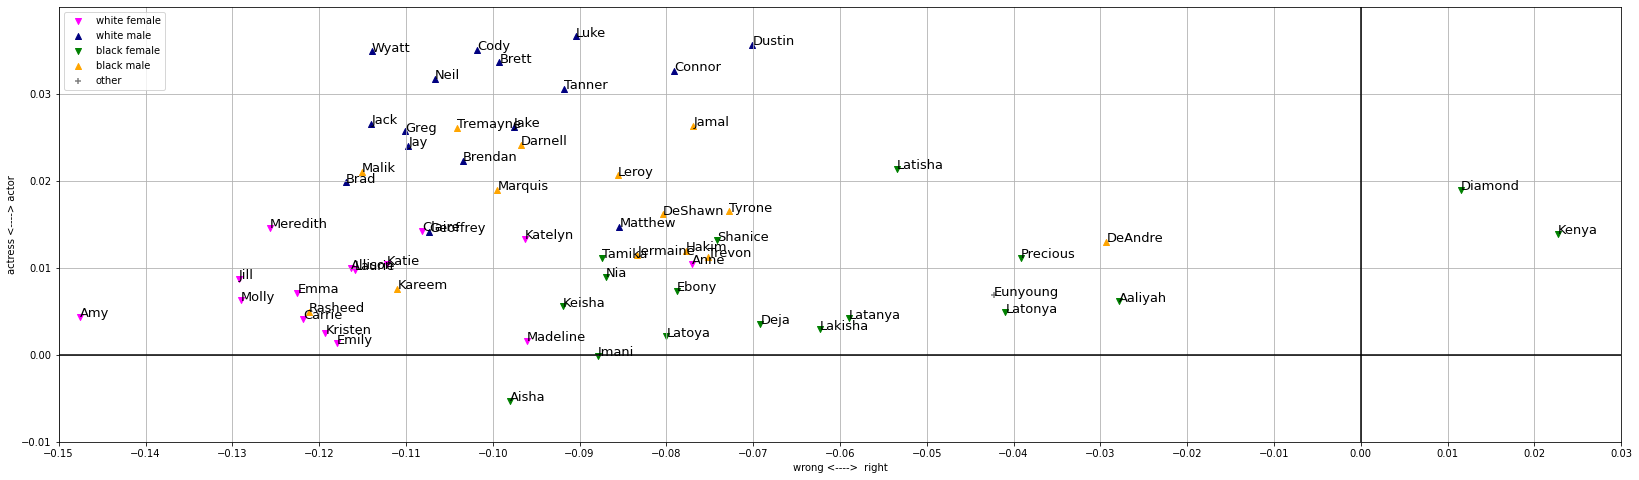

In [76]:
## Plotting

import matplotlib.pyplot as plt
%matplotlib inline

labels = {"white female":False, "white male":False, "black male":False, "black female":False, "other":False}


fig = plt.figure(figsize=(28,8))
ax = fig.add_subplot(1, 1, 1)
for item in sims_name:
    n, v1, v2 = item # item example: ['Allison', -0.11628705, 0.00995034]
    if n in wf:
        l = "white female"
        mr = "v"
        color_value = 'magenta'
    elif n in wm:
        l = "white male"
        mr = "^"
        color_value = 'navy'
    elif n in bf:
        l = "black female"
        mr = "v"
        color_value = 'green'
    elif n in bm:
        l = "black male"
        mr = "^"
        color_value = 'orange'
    else:
        l = "other"
        mr = "+"
        color_value = 'gray'
    if not labels[l]:
        plt.scatter(v1,v2, c=color_value, label=l, marker=mr)
        labels[l] = True
    else:
        plt.scatter(v1,v2, c=color_value, marker=mr) #v1 positive, v2 negative
    plt.annotate(n, (v1, v2), fontsize=13)
plt.xlabel("{} <---->  {}".format(vars1[2],vars1[1]))
plt.ylabel("{} <----> {}".format(vars2[2],vars2[1]))
plt.legend(loc="upper left")

xmin=-0.15
ymin=-0.01
xmax=0.03
ymax=0.04

major_ticks = np.arange(min(xmin,ymin), max(xmax,ymax), 0.01)
ax.set_xticks(major_ticks)
ax.set_yticks(major_ticks)
plt.grid(True)


plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.plot([0,0], [ymin,ymax], c='black')
plt.plot([xmin,xmax], [0,0], c='black')
plt.show()

## Pronoun bias

In [2]:
import numpy as np

def sentences2(prof,
               sentence="{} is a {}.",
               vars=['[MASK]','She','He']):
    mask = sentence.format(vars[0], prof)
    good = sentence.format(vars[1], prof)
    bad = sentence.format(vars[2], prof)
    output_tuple = mask, good, bad # output: '[MASK] is a doctor.', 'She is a doctor.', 'He is a doctor.'
    return list(output_tuple) # convert tuple into list   

def similarities2(prof, tokenizer, model,
                 sentence="{} is a {}.",
                 vars=['[MASK]','She','He']):
    s = sentences2(prof, sentence, vars)
    inputs = tokenizer(s, return_tensors="pt")
    mask_id = list(inputs['input_ids'][0]).index(103)

    outputs = model(**inputs)

    good = cosine_similarity(outputs[0][0][mask_id], outputs[0][1][mask_id]) #mask, she
    bad = cosine_similarity(outputs[0][0][mask_id], outputs[0][2][mask_id]) #mask, he

    return np.array([good.detach().numpy(), bad.detach().numpy()])

In [17]:
#Test
s = sentences2("doctor")
inputs = tokenizer(s, return_tensors="pt")
print("inputs:", inputs)
mask_id = list(inputs["input_ids"][0]).index(103)
print("mask_id:", mask_id)
outputs = model(**inputs)
print("output:", outputs)
print(outputs[0][0][1])

inputs: {'input_ids': tensor([[ 101,  103, 1110,  170, 3995,  119,  102],
        [ 101, 1153, 1110,  170, 3995,  119,  102],
        [ 101, 1124, 1110,  170, 3995,  119,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1]])}
mask_id: 1
output: BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.1772, -0.0566,  0.0177,  ...,  0.1888,  0.4390,  0.1492],
         [ 0.0159, -0.4131, -0.1218,  ...,  0.1904,  0.0376,  0.3120],
         [ 0.0820, -0.2815,  0.2733,  ...,  0.2882,  0.1813,  0.2917],
         ...,
         [-0.1690, -0.3901, -0.0678,  ...,  0.4102,  0.0730,  0.6369],
         [ 0.0902, -0.1656,  0.0347,  ...,  0.2215,  0.1952,  0.1319],
         [ 0.5806,  0.0072, -0.2361,  ...,  0.5933,  1.3430,  0.0353]],

        [[ 0.1023, -0.0482, -0.0157,  ...,  0.1060,  0.5262,  0.1380],

In [10]:
from tqdm.notebook import tqdm

profs = ["man","actor","doctor","nurse","engineer","software engineer", "teacher","politician",
         "actress","woman","singer","dancer","reporter","mathematician", "criminal", "writer",
         "painter","cashier","congressman","congresswoman", "police officer", "waiter","waitress",
         "headmaster", "headmistress",]

sims_profs = []
for prof in tqdm(profs):
    val = similarities2(prof, tokenizer, model)
    val = val[0] - val[1]
    sims_profs.append([prof, val])

In [11]:
similarities2("man", tokenizer, model)

array([0.6037612, 0.6142699], dtype=float32)

In [78]:
sims_profs[0]

['man', -0.010508478]

In [ ]:
sorted(sims_profs, key=lambda x: x[1])

[['waitress', -0.050192833],
 ['woman', -0.031276464],
 ['waiter', -0.026631653],
 ['doctor', -0.0237239],
 ['nurse', -0.022370279],
 ['actress', -0.02121067],
 ['cashier', -0.020751357],
 ['reporter', -0.017730951],
 ['criminal', -0.016246498],
 ['headmaster', -0.0151245],
 ['police officer', -0.013251305],
 ['actor', -0.010857701],
 ['man', -0.010508478],
 ['dancer', -0.010133386],
 ['headmistress', -0.009001613],
 ['singer', -0.00866127],
 ['teacher', -0.0068643093],
 ['engineer', -0.0046020746],
 ['software engineer', -0.0029562712],
 ['writer', 0.00031757355],
 ['painter', 0.0032230616],
 ['congresswoman', 0.01041162],
 ['congressman', 0.013192117],
 ['politician', 0.018993676],
 ['mathematician', 0.02041632]]

In [ ]:
Template_1 = "TARGET is ATTRIBUTE" 
# TARGET: male and female pronouns
# ATTRIBUTE: job titles from the Employee Salary dataset or the adjectives from the Positive and Negative taits dataset.
Template_2 = "TARGET can do ATTRIBUTE"
# ATTRIBUTE: skills from the O*NET dataset.

TypeError: ignored

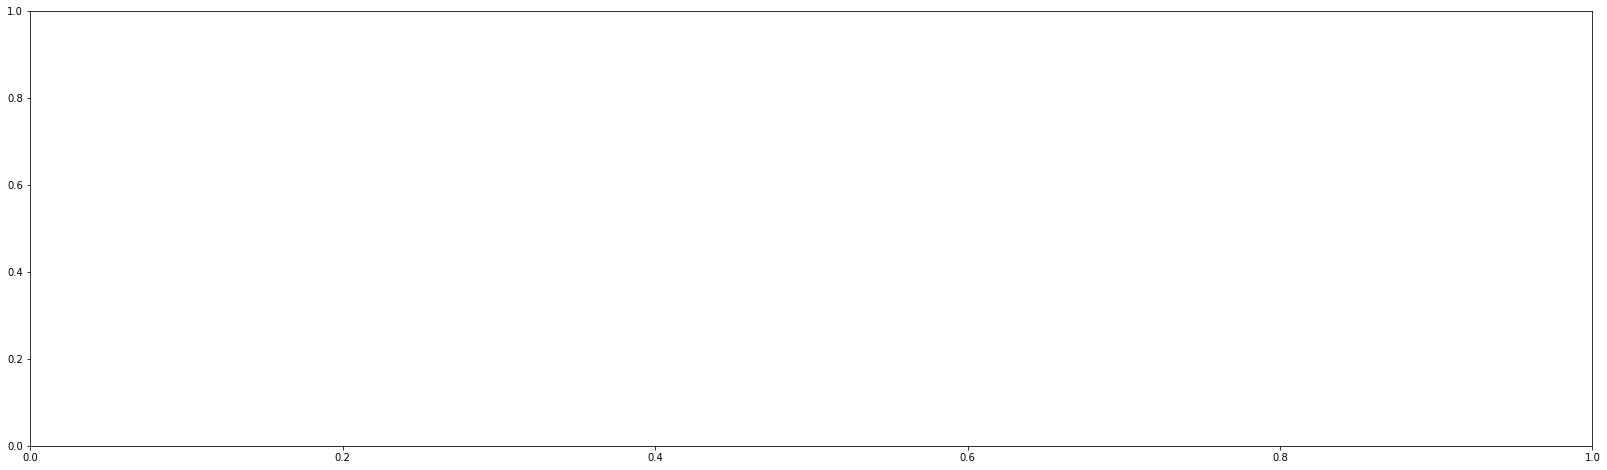

In [19]:
## Plotting

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(28,8))
ax = fig.add_subplot(1, 1, 1)

for item in sims_profs:
  prof, value = item
  plt.annotate(prof, value, fontsize=13)
#plt.xlabel("{} <---->  {}".format(vars1[2],vars1[1]))
#plt.ylabel("{} <----> {}".format(vars2[2],vars2[1]))
#plt.legend(loc="upper left")

#labels = {"white female":False, "white male":False, "black male":False, "black female":False, "other":False}

'''
fig = plt.figure(figsize=(28,8))
ax = fig.add_subplot(1, 1, 1)
for item in sims_name:
    n, v1, v2 = item # item example: ['Allison', -0.11628705, 0.00995034]
    if n in wf:
        l = "white female"
        mr = "v"
        color_value = 'magenta'
    elif n in wm:
        l = "white male"
        mr = "^"
        color_value = 'navy'
    elif n in bf:
        l = "black female"
        mr = "v"
        color_value = 'green'
    elif n in bm:
        l = "black male"
        mr = "^"
        color_value = 'orange'
    else:
        l = "other"
        mr = "+"
        color_value = 'gray'
    if not labels[l]:
        plt.scatter(v1,v2, c=color_value, label=l, marker=mr)
        labels[l] = True
    else:
        plt.scatter(v1,v2, c=color_value, marker=mr)
    plt.annotate(n, (v1, v2), fontsize=13)
plt.xlabel("{} <---->  {}".format(vars1[2],vars1[1]))
plt.ylabel("{} <----> {}".format(vars2[2],vars2[1]))
plt.legend(loc="upper left")
'''
xmin=-0.15
ymin=-0.01
xmax=0.03
ymax=0.04

major_ticks = np.arange(min(xmin,ymin), max(xmax,ymax), 0.01)
ax.set_xticks(major_ticks)
ax.set_yticks(major_ticks)
plt.grid(True)


plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.plot([0,0], [ymin,ymax], c='black')
plt.plot([xmin,xmax], [0,0], c='black')
plt.show()

## Other calculations and preparing CSV

### Counting tokens

In [41]:
no_tokens = []
for name in names:
    token_len = len(tokenizer(name)['input_ids'])-2
    no_tokens.append(token_len)

In [42]:
is_black = [1  if (n in bm+bf) else 0 for n in names]
is_female = [1 if (n in wf+bf) else 0 for n in names]

df = [{'name':i,'is_black':j,'is_female':k} for i,j,k in zip(names, is_black, is_female)]
import pandas as pd
import numpy as np
df = pd.DataFrame(df)

In [43]:
df["no_tokens"] = no_tokens

In [44]:
df[(df.is_black==1)&(df.is_female==1)]

,name,is_black,is_female,no_tokens
31,Aisha,1,1,2
32,Ebony,1,1,3
33,Keisha,1,1,3
34,Kenya,1,1,1
35,Latonya,1,1,3
36,Lakisha,1,1,3
37,Latoya,1,1,3
38,Tamika,1,1,2
39,Imani,1,1,2
40,Shanice,1,1,2


In [45]:
df2 = pd.DataFrame(sims, columns=["name","right-wrong", "actor-actress"])

In [46]:
df2

,name,right-wrong,actor-actress
0,Allison,-0.116287,0.009950
1,Anne,-0.077043,0.010420
2,Carrie,-0.121847,0.004095
3,Emily,-0.117990,0.001316
4,Jill,-0.129227,0.008701
...,...,...,...
58,Marquis,-0.099449,0.019004
59,Malik,-0.115047,0.021020
60,Trevon,-0.075159,0.011282
61,Tyrone,-0.072743,0.016502


In [47]:
df = df.merge(df2[["name","right-wrong"]])

In [48]:
df

,name,is_black,is_female,no_tokens,right-wrong
0,Allison,0,1,1,-0.116287
1,Anne,0,1,1,-0.077043
2,Carrie,0,1,1,-0.121847
3,Emily,0,1,1,-0.117990
4,Jill,0,1,1,-0.129227
...,...,...,...,...,...
58,Marquis,1,0,1,-0.099449
59,Malik,1,0,1,-0.115047
60,Trevon,1,0,3,-0.075159
61,Tyrone,1,0,1,-0.072743


In [49]:
df[(df.is_black==1)&(df.is_female==1)][["actor-actress","rich-poor"]].mean()

KeyError: ignored

In [ ]:
avg_wm=[-0.023486, 0.027307]
avg_wf=[-0.027589, 0.007907]
avg_bm=[-0.004946, 0.016434]
avg_bf=[0.007205, 0.007651]

In [ ]:
w_mf_diff = abs(avg_wf[1]-avg_wm[1])

In [ ]:
f_wb_diff = abs(avg_bf[0]-avg_wf[0])

In [ ]:
f_wb_diff/w_mf_diff

In [ ]:
df.to_csv("names_BERT.csv", index=False)